<a href="https://colab.research.google.com/github/petrucior/verilog/blob/main/maquinaMultiplicacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto RTL - Verilog
---------------

Author: Petrúcio Medeiros

In [ ]:
# Instalando bibliotecas
%%bash
sudo apt-get update
sudo apt-get install verilog

# Datapath

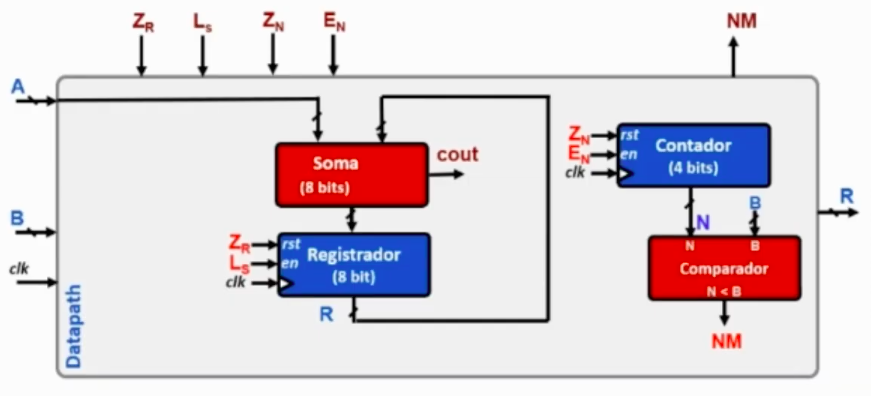

In [8]:
%%file datapath.v

/*

  Módulo do datapath

*/
module datapath(clk, A, B, Zr, Ls, Zn, En, NM, R);
  // Declaração de portas
  input [3:0] A, B;
  input clk, Zr, Ls, Zn, En;
  output reg NM;
  output reg [7:0] R;

  reg [3:0] N;

  // Iniciando valores de tot e tm
  initial begin
    R = 8'd0;
    N = 4'd0;
    NM = 1'd1;
  end

  // Descrição comportamental do somador e registrador
  always @(posedge clk, Zr, Ls) begin
    if ( Zr == 1 ) R = 8'd0;
    else if ( Ls == 1 ) R = R + A;
  end

  // Descrição comportamental do contador e comparador
  always @(posedge clk, Zn, En) begin
    if ( Zn == 1 ) N = 4'd0;
    else if ( En == 1 ) N = N + 4'd1;

    if ( N < B ) NM = 1'd1;
    else NM = 1'd0;
  end
endmodule

/*

 Módulo de teste

*/
module teste(); // Definindo um módulo de teste, onde adiciono valores
parameter nbits = 32; // 2^{entradas} = 2^{4} = 16
parameter A = 4'd3;
parameter B = 4'd2;
reg [4:0] counter; // Criando um registro de 5 bits para entradas
wire [8:0] z; // Declarando um fio de saída do "datapath"
integer k; // Declarando um inteiro para percorrer todas as possibilidades
	datapath t(counter[0], A, B, counter[3], counter[1], counter[4], counter[2], z[0], z[8:1]);
	initial begin // // Início do bloco de comandos
		$display("clk A3210 B3210 Zr Ls Zn En | NM R76543210 "); // printf apenas com string
		$monitor(" %1b   %4b  %4b  %1b  %1b  %1b  %1b |  %1b %8b ", counter[0], A, B, counter[3], counter[1], counter[4], counter[2], z[0], z[8:1]); // printf passando variáveis
    counter = 0;
    /*
    Percorre a quantidade de saídas e armazena no contador
    */
		for (k=1; k<nbits; k=k+1)
     #1 counter = k;
		$finish;
	end // Fim do bloco de comandos
endmodule

Overwriting datapath.v


In [9]:
%%bash
iverilog datapath.v -o datapath
vvp datapath

clk A3210 B3210 Zr Ls Zn En | NM R76543210 
 0   0011  0010  0  0  0  0 |  1 00000000 
 1   0011  0010  0  0  0  0 |  1 00000000 
 0   0011  0010  0  1  0  0 |  1 00000011 
 1   0011  0010  0  1  0  0 |  1 00000110 
 0   0011  0010  0  0  0  1 |  1 00000110 
 1   0011  0010  0  0  0  1 |  0 00000110 
 0   0011  0010  0  1  0  1 |  0 00001001 
 1   0011  0010  0  1  0  1 |  0 00001100 
 0   0011  0010  1  0  0  0 |  0 00000000 
 1   0011  0010  1  0  0  0 |  0 00000000 
 0   0011  0010  1  1  0  0 |  0 00000000 
 1   0011  0010  1  1  0  0 |  0 00000000 
 0   0011  0010  1  0  0  1 |  0 00000000 
 1   0011  0010  1  0  0  1 |  0 00000000 
 0   0011  0010  1  1  0  1 |  0 00000000 
 1   0011  0010  1  1  0  1 |  0 00000000 
 0   0011  0010  0  0  1  0 |  1 00000000 
 1   0011  0010  0  0  1  0 |  1 00000000 
 0   0011  0010  0  1  1  0 |  1 00000011 
 1   0011  0010  0  1  1  0 |  1 00000110 
 0   0011  0010  0  0  1  1 |  1 00000110 
 1   0011  0010  0  0  1  1 |  1 00000110 
 0   0011 

# Control

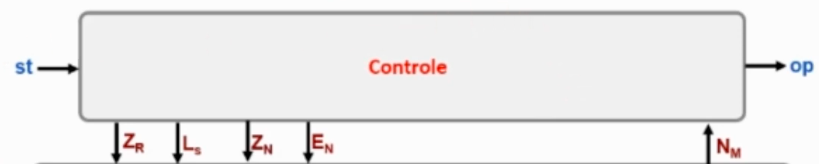

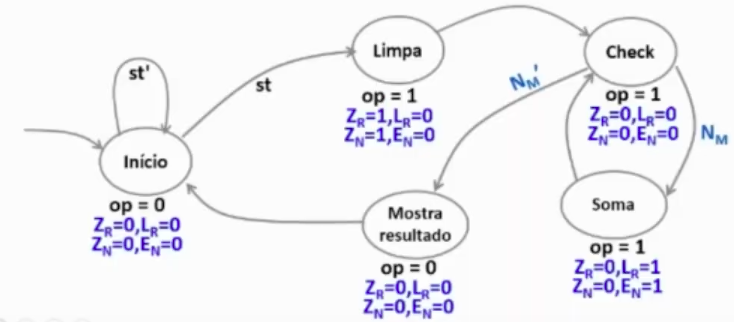

In [14]:
%%file control.v

/*

Módulo control

*/
module control ( clk, rst, st, Nm, op, Zr, Ls, Zn, En );
  // Declaração de portas
  input clk, rst, st, Nm;
  output reg op, Zr, Ls, Zn, En;

  // Declarando estados da máquina
  reg [2:0] estado_atual, estado_proximo;

  parameter Inicio = 3'b000,
            Limpa = 3'b001,
            Check = 3'b010,
            Soma = 3'b011,
            Mostra = 3'b100;

  // Reset e mudança de estado
  always @(posedge clk, posedge rst) begin
    if ( clk == 1 ) begin
      if ( rst == 1 ) estado_atual <= Inicio;
      else estado_atual <= estado_proximo;
    end
  end

  // Descrição comportamental
  always @(estado_atual, st, Nm) begin
    case ({estado_atual})
      Inicio : begin
        op = 0;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        if ( st == 0 ) estado_proximo = Inicio;
        else estado_proximo = Limpa;
      end
      Limpa : begin
        op = 1;
        // Setando variaveis
        Zr = 1;
        Ls = 0;
        Zn = 1;
        En = 0;
        estado_proximo = Check;
      end
      Check : begin
        op = 1;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        if ( Nm == 0 ) estado_proximo = Mostra;
        else estado_proximo = Soma;
      end
      Soma : begin
        op = 1;
        // Setando variaveis
        Zr = 0;
        Ls = 1;
        Zn = 0;
        En = 1;
        estado_proximo = Check;
      end
      Mostra : begin
        op = 0;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        estado_proximo = Inicio;
      end
    endcase
  end
endmodule


/*

 Módulo de teste

*/
module teste(); // Definindo um módulo de teste, onde adiciono valores
parameter nbits = 16; // 2^{entradas} = 2^{4} = 16
reg reset = 1'b1;
reg [2:0] counter; // Criando um registro de 4 bits para entradas
wire [4:0] z; // Declarando um fio de saída do "control"
integer k; // Declarando um inteiro para percorrer todas as possibilidades
  // clk, rst, st, Nm, op, Zr, Ls, Zn, En
	control t(counter[0], reset, counter[1], counter[2], z[0], z[1], z[2], z[3], z[4]);
	initial begin // // Início do bloco de comandos
		$display("clk rst st Nm | op Zr Ls Zn En"); // printf apenas com string
		$monitor(" %1b   %1b  %1b  %1b  |  %1b  %1b  %1b  %1b  %1b", counter[0], reset, counter[1], counter[2], z[0], z[1], z[2], z[3], z[4]); // printf passando variáveis
    counter = 0;
    /*
    Percorre a quantidade de saídas e armazena no contador
    */
		for (k=1; k<nbits; k=k+1) begin
     #1 counter = k;
     #2 if ( k < 3 ) reset = 1'b0;
    end
		$finish;
	end // Fim do bloco de comandos
endmodule

Overwriting control.v


In [15]:
%%bash
iverilog control.v -o control
vvp control

clk rst st Nm | op Zr Ls Zn En
 0   1  0  0  |  x  x  x  x  x
 1   1  0  0  |  0  0  0  0  0
 1   0  0  0  |  0  0  0  0  0
 0   0  1  0  |  0  0  0  0  0
 1   0  1  0  |  1  1  0  1  0
 0   0  0  1  |  1  1  0  1  0
 1   0  0  1  |  1  0  0  0  0
 0   0  1  1  |  1  0  0  0  0
 1   0  1  1  |  1  0  1  0  1
 0   0  0  0  |  1  0  1  0  1
 1   0  0  0  |  1  0  0  0  0
 0   0  1  0  |  1  0  0  0  0
 1   0  1  0  |  0  0  0  0  0
 0   0  0  1  |  0  0  0  0  0
 1   0  0  1  |  0  0  0  0  0
 0   0  1  1  |  0  0  0  0  0
 1   0  1  1  |  1  1  0  1  0


# Sistema Digital = Datapath + Control

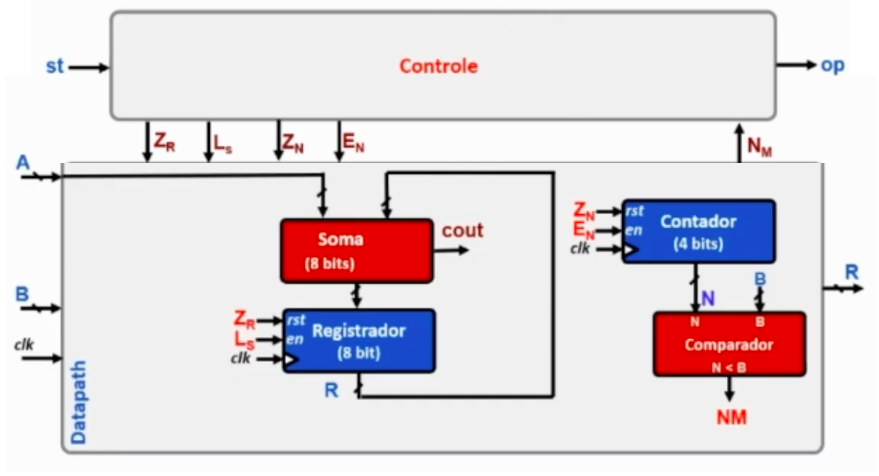

In [16]:
%%file sistema.v

/*

  Datapath
  
*/
module datapath(clk, A, B, Zr, Ls, Zn, En, NM, R);
  // Declaração de portas
  input [3:0] A, B;
  input clk, Zr, Ls, Zn, En;
  output reg NM;
  output reg [7:0] R;

  reg [3:0] N;

  // Iniciando valores de tot e tm
  initial begin
    R = 8'd0;
    N = 4'd0;
    NM = 1'd1;
  end

  // Descrição comportamental do somador e registrador
  always @(posedge clk, Zr, Ls) begin
    if ( Zr == 1 ) R = 8'd0;
    else if ( Ls == 1 ) R = R + A;
  end

  // Descrição comportamental do contador e comparador
  always @(posedge clk, Zn, En) begin
    if ( Zn == 1 ) N = 4'd0;
    else if ( En == 1 ) N = N + 4'd1;

    if ( N < B ) NM = 1'd1;
    else NM = 1'd0;
  end
endmodule

/*

  Control

*/
module control ( clk, rst, st, Nm, op, Zr, Ls, Zn, En );
  // Declaração de portas
  input clk, rst, st, Nm;
  output reg op, Zr, Ls, Zn, En;

  // Declarando estados da máquina
  reg [2:0] estado_atual, estado_proximo;

  parameter Inicio = 3'b000,
            Limpa = 3'b001,
            Check = 3'b010,
            Soma = 3'b011,
            Mostra = 3'b100;

  // Reset e mudança de estado
  always @(posedge clk, posedge rst) begin
    if ( clk == 1 ) begin
      if ( rst == 1 ) estado_atual <= Inicio;
      else estado_atual <= estado_proximo;
    end
  end

  // Descrição comportamental
  always @(estado_atual, st, Nm) begin
    case ({estado_atual})
      Inicio : begin
        op = 0;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        if ( st == 0 ) estado_proximo = Inicio;
        else estado_proximo = Limpa;
      end
      Limpa : begin
        op = 1;
        // Setando variaveis
        Zr = 1;
        Ls = 0;
        Zn = 1;
        En = 0;
        estado_proximo = Check;
      end
      Check : begin
        op = 1;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        if ( Nm == 0 ) estado_proximo = Mostra;
        else estado_proximo = Soma;
      end
      Soma : begin
        op = 1;
        // Setando variaveis
        Zr = 0;
        Ls = 1;
        Zn = 0;
        En = 1;
        estado_proximo = Check;
      end
      Mostra : begin
        op = 0;
        // Setando variaveis
        Zr = 0;
        Ls = 0;
        Zn = 0;
        En = 0;
        estado_proximo = Inicio;
      end
    endcase
  end
endmodule

/*

 Módulo de teste

*/
module teste(); // Definindo um módulo de teste, onde adiciono valores
parameter nbits = 32;
reg reset = 1'b1;

/*
  BA = A + A + A + A
       --------------
         B vezes
*/
parameter A = 4'd1;
parameter B = 4'd4;

reg st = 1'b0;

reg [3:0] counter; // Criando um registro de 4 bits para entradas
wire op, Zr, Ls, Zn, En, Nm; // fios
wire [7:0] R;
integer k; // Declarando um inteiro para percorrer todas as possibilidades
  // clk, rst, st, Nm, op, Zr, Ls, Zn, En
	control c(counter[0], reset, counter[1], Nm, op, Zr, Ls, Zn, En);
  // clk, A, B, Zr, Ls, Zn, En, NM, R)
  datapath d(counter[0], A, B, Zr, Ls, Zn, En, Nm, R);
	initial begin // // Início do bloco de comandos
		$display("clk rst st A3210 B3210 Nm op Zr Ls Zn En | R76543210"); // printf apenas com string
		$monitor(" %1b   %1b  %1b   %4b  %4b  %1b  %1b  %1b  %1b  %1b  %1b |  %8b", counter[0], reset, counter[1], A, B, Nm, op, Zr, Ls, Zn, En, R); // printf passando variáveis
    counter = 0;
		for (k=1; k<nbits; k=k+1) begin
     #1 counter = k;
     #2 if ( k < 3 ) reset = 1'b0;
    end
		$finish;
	end // Fim do bloco de comandos
endmodule


Overwriting sistema.v


In [17]:
%%bash
iverilog sistema.v -o sistema
vvp sistema

clk rst st A3210 B3210 Nm op Zr Ls Zn En | R76543210
 0   1  0   0001  0100  1  x  x  x  x  x |  00000000
 1   1  0   0001  0100  1  0  0  0  0  0 |  00000000
 1   0  0   0001  0100  1  0  0  0  0  0 |  00000000
 0   0  1   0001  0100  1  0  0  0  0  0 |  00000000
 1   0  1   0001  0100  1  1  1  0  1  0 |  00000000
 0   0  0   0001  0100  1  1  1  0  1  0 |  00000000
 1   0  0   0001  0100  1  1  0  0  0  0 |  00000000
 0   0  1   0001  0100  1  1  0  0  0  0 |  00000000
 1   0  1   0001  0100  1  1  0  1  0  1 |  00000001
 0   0  0   0001  0100  1  1  0  1  0  1 |  00000001
 1   0  0   0001  0100  1  1  0  0  0  0 |  00000010
 0   0  1   0001  0100  1  1  0  0  0  0 |  00000010
 1   0  1   0001  0100  1  1  0  1  0  1 |  00000011
 0   0  0   0001  0100  1  1  0  1  0  1 |  00000011
 1   0  0   0001  0100  0  1  0  0  0  0 |  00000100
 0   0  1   0001  0100  0  1  0  0  0  0 |  00000100
 1   0  1   0001  0100  0  0  0  0  0  0 |  00000100
 0   0  0   0001  0100  0  0  0  0  0  0 |  00